In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
DATA_DIR = '/Users/jameskierdoliguez/Downloads/Rice_Leaf_AUG' 

In [3]:
#class overview rani
image_extensions = ('.jpg', '.jpeg', '.png')
class_counts = {}

for root, dirs, files in os.walk(DATA_DIR):
    class_name = os.path.basename(root)
    
    if root == DATA_DIR:
        continue
    
    image_count = 0
    for file in files:
        if file.lower().endswith(image_extensions):
            image_count += 1
    
   
    if image_count > 0:
        class_counts[class_name] = image_count


print("Images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


total_images = sum(class_counts.values())
print(f"\nTotal images across all classes: {total_images}")

Images per class:
Sheath Blight: 632
Leaf Blast: 634
Bacterial Leaf Blight: 636
Healthy Rice Leaf: 653
Brown Spot 2: 646
Leaf scald: 628

Total images across all classes: 3829


In [4]:
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file == '.DS_Store':
            os.remove(os.path.join(root, file))


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [5]:
train_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 3066 images belonging to 6 classes.
Found 763 images belonging to 6 classes.


In [6]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
model.fit(train_data, validation_data=val_data, epochs=20)

/opt/anaconda3/envs/toki/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 283ms/step - accuracy: 0.2665 - loss: 1.9960 - val_accuracy: 0.4587 - val_loss: 1.3934
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 266ms/step - accuracy: 0.4830 - loss: 1.3265 - val_accuracy: 0.5570 - val_loss: 1.1980
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 270ms/step - accuracy: 0.5637 - loss: 1.1303 - val_accuracy: 0.5334 - val_loss: 1.2027
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 288ms/step - accuracy: 0.6146 - loss: 1.0154 - val_accuracy: 0.5623 - val_loss: 1.1632
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 271ms/step - accuracy: 0.6545 - loss: 0.9395 - val_accuracy: 0.5806 - val_loss: 1.1370
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 268ms/step - accuracy: 0.6945 - loss: 0.8405 - val_accuracy: 0.5806 - val_loss: 1.1519
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 268ms/step - accuracy: 0.7100 - loss: 0.8079 - val_accuracy: 0.5740 - val_loss: 1.1369
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 268ms/step - accuracy: 0.6965 - loss: 0.7858 - val_accu

In [8]:
base_model.trainable = True

# Freeze the first 100 layers to preserve low-level features
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 354ms/step - accuracy: 0.4595 - loss: 1.9891 - val_accuracy: 0.7313 - val_loss: 0.7815
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 34s 351ms/step - accuracy: 0.6659 - loss: 0.8893 - val_accuracy: 0.7431 - val_loss: 0.7670
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 34s 353ms/step - accuracy: 0.7315 - loss: 0.7235 - val_accuracy: 0.7457 - val_loss: 0.7873
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 364ms/step - accuracy: 0.7766 - loss: 0.6511 - val_accuracy: 0.7484 - val_loss: 0.7841
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 374ms/step - accuracy: 0.7842 - loss: 0.5985 - val_accuracy: 0.7497 - val_loss: 0.8013
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 365ms/step - accuracy: 0.8280 - loss: 0.4815 - val_accuracy: 0.7510 - val_loss: 0.8094
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8148 - loss: 0.5108 - val_accuracy: 0.7300 - val_loss: 0.7856
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 365ms/step - accuracy: 0.8338 - loss: 0.4651 - val_accu

In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)


In [10]:
import numpy as np
print(train_data.classes)
print(np.unique(train_data.classes, return_counts=True))


[0 0 0 ... 5 5 5]
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([509, 517, 523, 508, 503, 506]))


In [11]:
class_names = list(train_data.class_indices.keys())
print("Class labels:", class_names)


Class labels: ['Bacterial Leaf Blight', 'Brown Spot 2', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Sheath Blight']


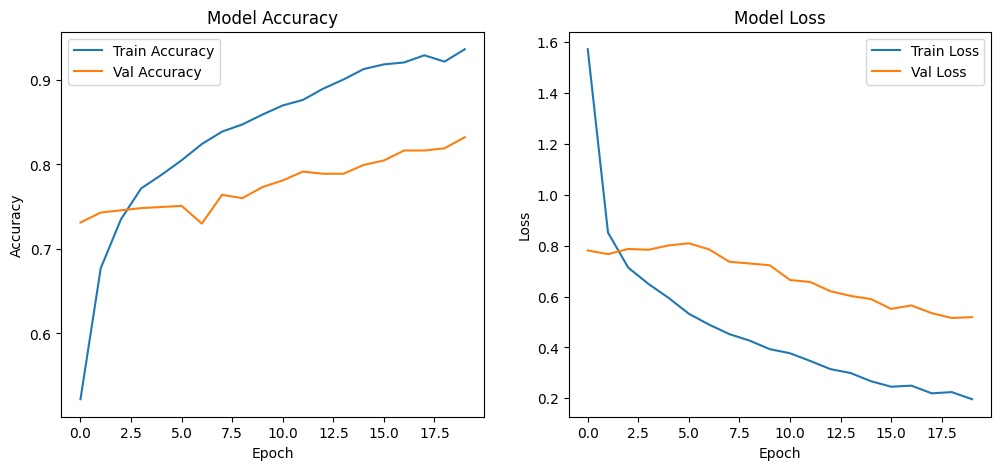

In [17]:
#Training vs Validation Accuracy and Loss

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [14]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


NameError: name 'X_test' is not defined

In [15]:
#Class Distribution in Training Data
import seaborn as sns
import pandas as pd

labels = train_generator.classes
class_names = train_generator.class_indices
labels_df = pd.DataFrame(labels, columns=['Class'])
labels_df['Class'] = labels_df['Class'].map({v: k for k, v in class_names.items()})

sns.countplot(data=labels_df, x='Class')
plt.title('Training Data Class Distribution')
plt.xticks(rotation=45)
plt.show()


ModuleNotFoundError: No module named 'seaborn'

NameError: name 'X_test' is not defined

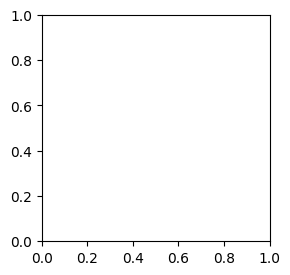

In [16]:
#Sample Predictions with Images
import matplotlib.pyplot as plt

num_images = 9
plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    img = X_test[i]
    plt.imshow(img)
    pred_label = class_names[np.argmax(model.predict(img[np.newaxis, ...]))]
    true_label = class_names[np.argmax(y_test[i])]
    plt.title(f"True: {true_label}\\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [1]:
img_path = '/Users/jameskierdoliguez/Downloads/Rice Leaf Disease Images/Blast/BLAST1_061.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array = img_array / 255.0 


NameError: name 'image' is not defined

In [26]:
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


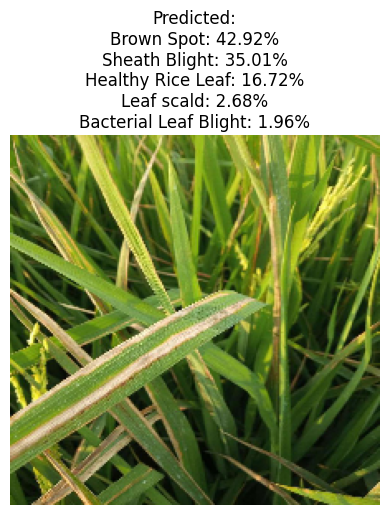

In [27]:
sorted_indices = np.argsort(prediction[0])[::-1]
top5_predictions = []
for i in range(5):
    idx = sorted_indices[i]
    class_name = class_names[idx]
    confidence_score = prediction[0][idx] * 100
    top5_predictions.append(f"{class_name}: {confidence_score:.2f}%")

# Create the title string with all top predictions
title_string = "Predicted:\n" + "\n".join(top5_predictions)

plt.imshow(img)
plt.axis('off')
plt.title(title_string)
plt.show()

In [ ]:
# Predict on all test images
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Individual scores if needed
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")